In [1]:
import netCDF4 as nc
import numpy as np
import iris.coords as coords
import cf_units
import iris.cube as icube
import pdb
from scipy.stats import kurtosis
from scipy import stats
import seaborn as sns
import scipy.stats as stats
import random
import matplotlib.pyplot as plt
import math
import numpy.ma as ma
import datetime as dt
import iris.plot as iplt
import matplotlib as mpl
import iris
# import functions
from FidelityTest import calcDistrStatistic, timeseries_fid_test, plot_fidelity_testing, get_cube_limits, plotStatsMeasures
from BiasCorrection import mean_bias_correction, kurtosis_power_transform, ratio_correction,Quantile_mapping,ks_compare_distributions,mean_correction, calculate_return_periods,plot_return_periods

In [2]:
# load model data
file_path = '/home/h06/jdavie/ClimateSecurity/Data for Yiwei/Hunan_summer_tas_model_DePreSys3.nc'  
summer_tem_model = nc.Dataset(file_path, mode='r')
summer_tem_model.variables.keys()
tem_model3 = summer_tem_model.variables['air_temperature'][:]
tem_model3.shape

(2, 30, 40)

In [3]:
# load model data
file_path = '/home/h06/jdavie/ClimateSecurity/Data for Yiwei/Hunan_summer_tas_model_DePreSys4.nc'  
summer_tem_model = nc.Dataset(file_path, mode='r')
summer_tem_model.variables.keys()
tem_model4 = summer_tem_model.variables['tas'][:]
tem_model4.shape

(10, 30, 10)

In [4]:
# load obs data
file_path = '/home/h06/jdavie/ClimateSecurity/Data for Yiwei/Hunan_summer_tas_obs_ERA5-Land.nc'  
summer_tem_obs = nc.Dataset(file_path, mode='r')
summer_tem_obs.variables.keys()
tem_obs = summer_tem_obs.variables['t2m'][:]
tem_obs.shape

(30,)

In [5]:
# reshape simulations from 3 dimensions to 2 dimensions
def reshape_model(simulations):  
    # reshape model simulations
    n_years = simulations.shape[1]  
    n_months = simulations.shape[2]  
    model = simulations[:].reshape(n_years, -1)
    return model

In [8]:
# new reshape simulations from 3 dimensions to 2 dimensions
def new_reshape_model(simulations):  
    # reshape model simulations
    n_years = simulations.shape[1]  
    n_months = simulations.shape[2]  
    new_model = np.transpose(simulations[:], (1, 0, 2))
    new_model = new_model.reshape(n_years, -1)
    return new_model

In [9]:
model3 = reshape_model(tem_model3)
model4 = reshape_model(tem_model4)
model4.shape

new_model3 = new_reshape_model(tem_model3)
new_model4 = new_reshape_model(tem_model4)

In [10]:
# create cube for plotting
def convert_array_cube(data):
    time_coord = coords.DimCoord(range(data.shape[0]), standard_name='time')
    if data.ndim > 1:
        year_coord = coords.DimCoord(range(data.shape[1]), standard_name='realization')
        # define units for each coord
        year_coord.units = cf_units.Unit('years since 1992', calendar='gregorian')
        cube = iris.cube.Cube(data, dim_coords_and_dims=[(time_coord, 0), (year_coord, 1)])
    else:
        cube = iris.cube.Cube(data, dim_coords_and_dims=[(time_coord, 0)])
    cube.long_name = 'Hunan_Summer_data'
    cube.units = 'celsius'
    return cube

In [11]:
mod3 = convert_array_cube(model3)
mod4 = convert_array_cube(model4)
obs = convert_array_cube(tem_obs)

new_mod3 = convert_array_cube(new_model3)
new_mod4 = convert_array_cube(new_model4)

In [49]:
def plotting_obs_mod(obs, mod, mod_corrected):
    obs_data = obs.data
    mod_data = mod.data
    mod_corrected_data = mod_corrected
    years = np.arange(1992, 2022)
    mod_mean = mod_data.mean(axis=1)
    mod_std = mod_data.std(axis=1)   
    mod_corrected_mean = mod_corrected_data.mean(axis=1)
    mod_corrected_std = mod_corrected_data.std(axis=1)
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    axes[0].plot(years, obs_data, label='Observations', color='black', linewidth=2, linestyle='--')
    for i in range(mod_data.shape[1]):
        axes[0].plot(years, mod_data[:, i], color='grey', alpha=0.2)
    axes[0].plot(years, mod_mean, label='DePreSys4_mean', color='red', linewidth=2, linestyle='--')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Temperature')
    axes[0].set_title('Original Model')
    axes[0].legend()
    axes[1].plot(years, obs_data, label='Observations', color='black', linewidth=2, linestyle='--')
    for i in range(mod_corrected_data.shape[1]):
        axes[1].plot(years, mod_corrected_data[:, i], color='grey', alpha=0.2)
    axes[1].plot(years, mod_corrected_mean, label='DePreSys4_corrected_mean', color='blue', linewidth=2, linestyle='--')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Temperature')
    axes[1].set_title('Corrected Model')
    axes[1].legend()
    plt.tight_layout()
    plt.show()

Hunan Summer Temperature for DePreSys3 Data:


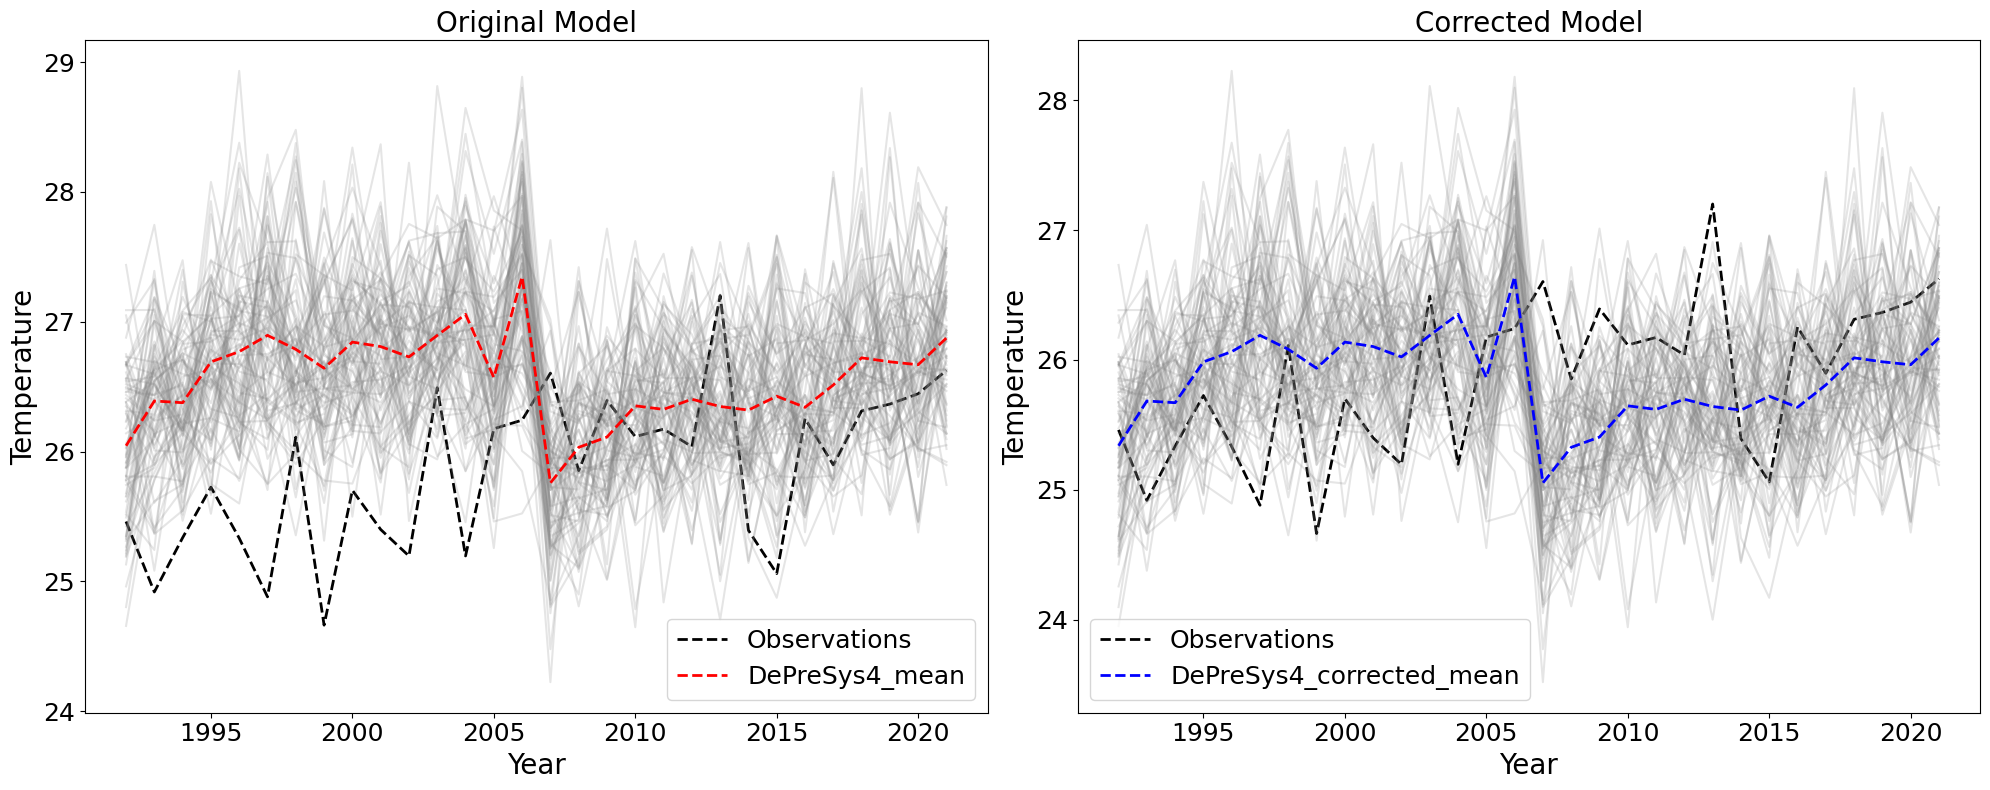

Hunan Summer Temperature for DePreSys4 Data:


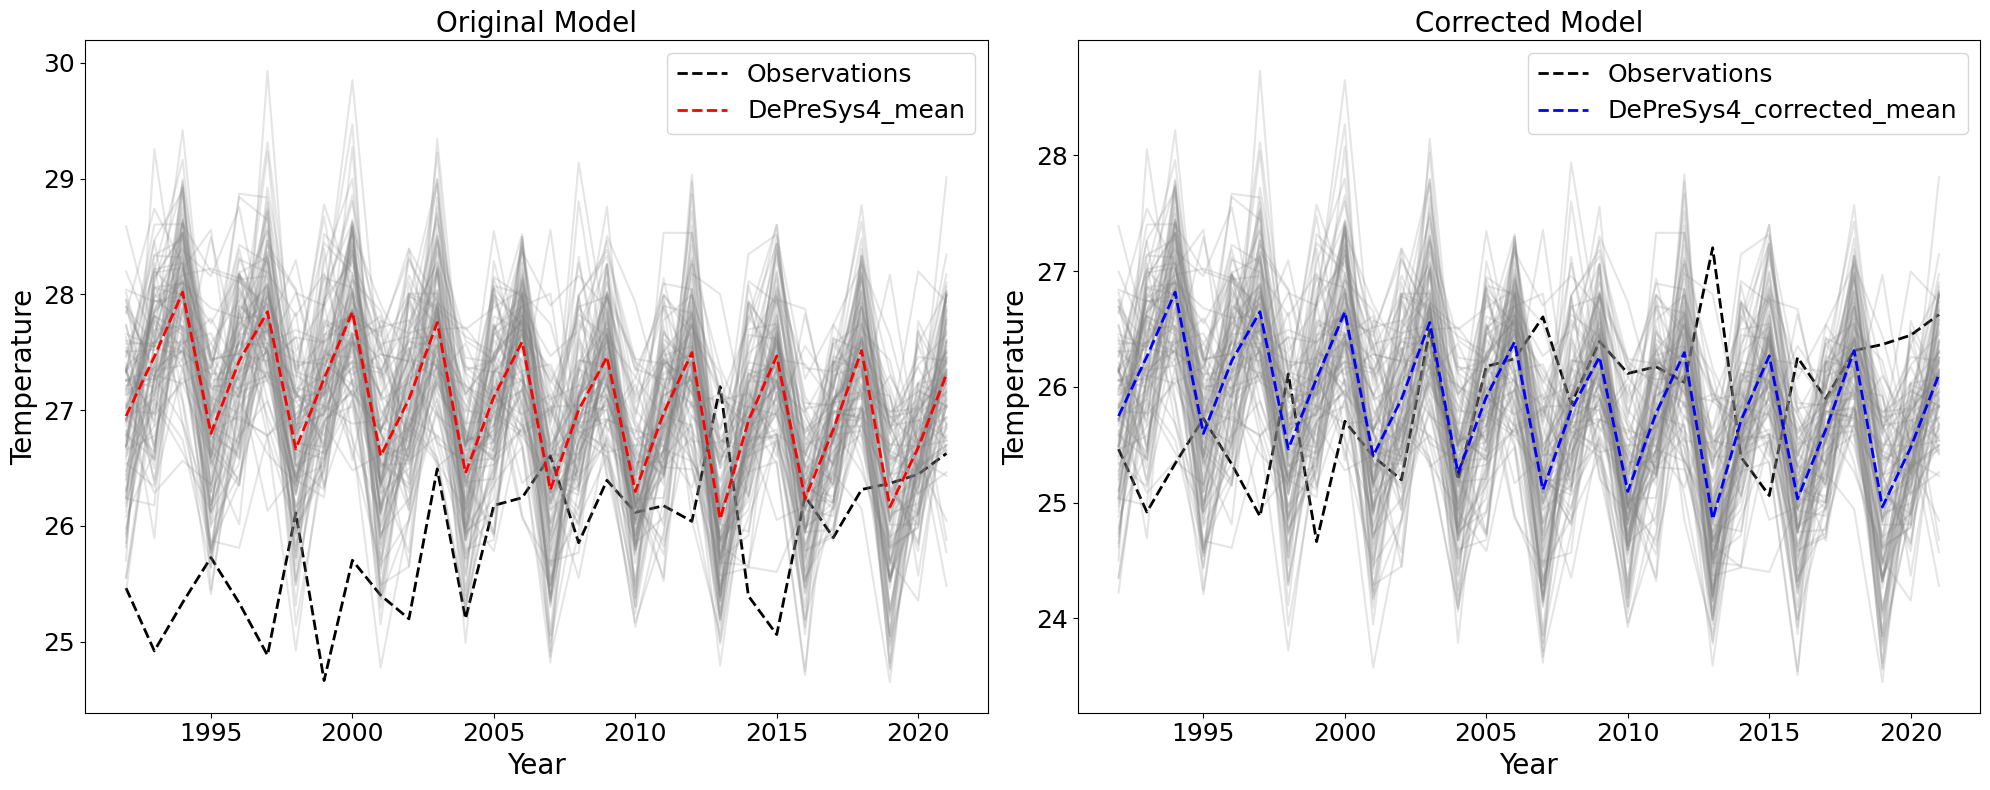

Hunan Summer Temperature for DePreSys3 Data:


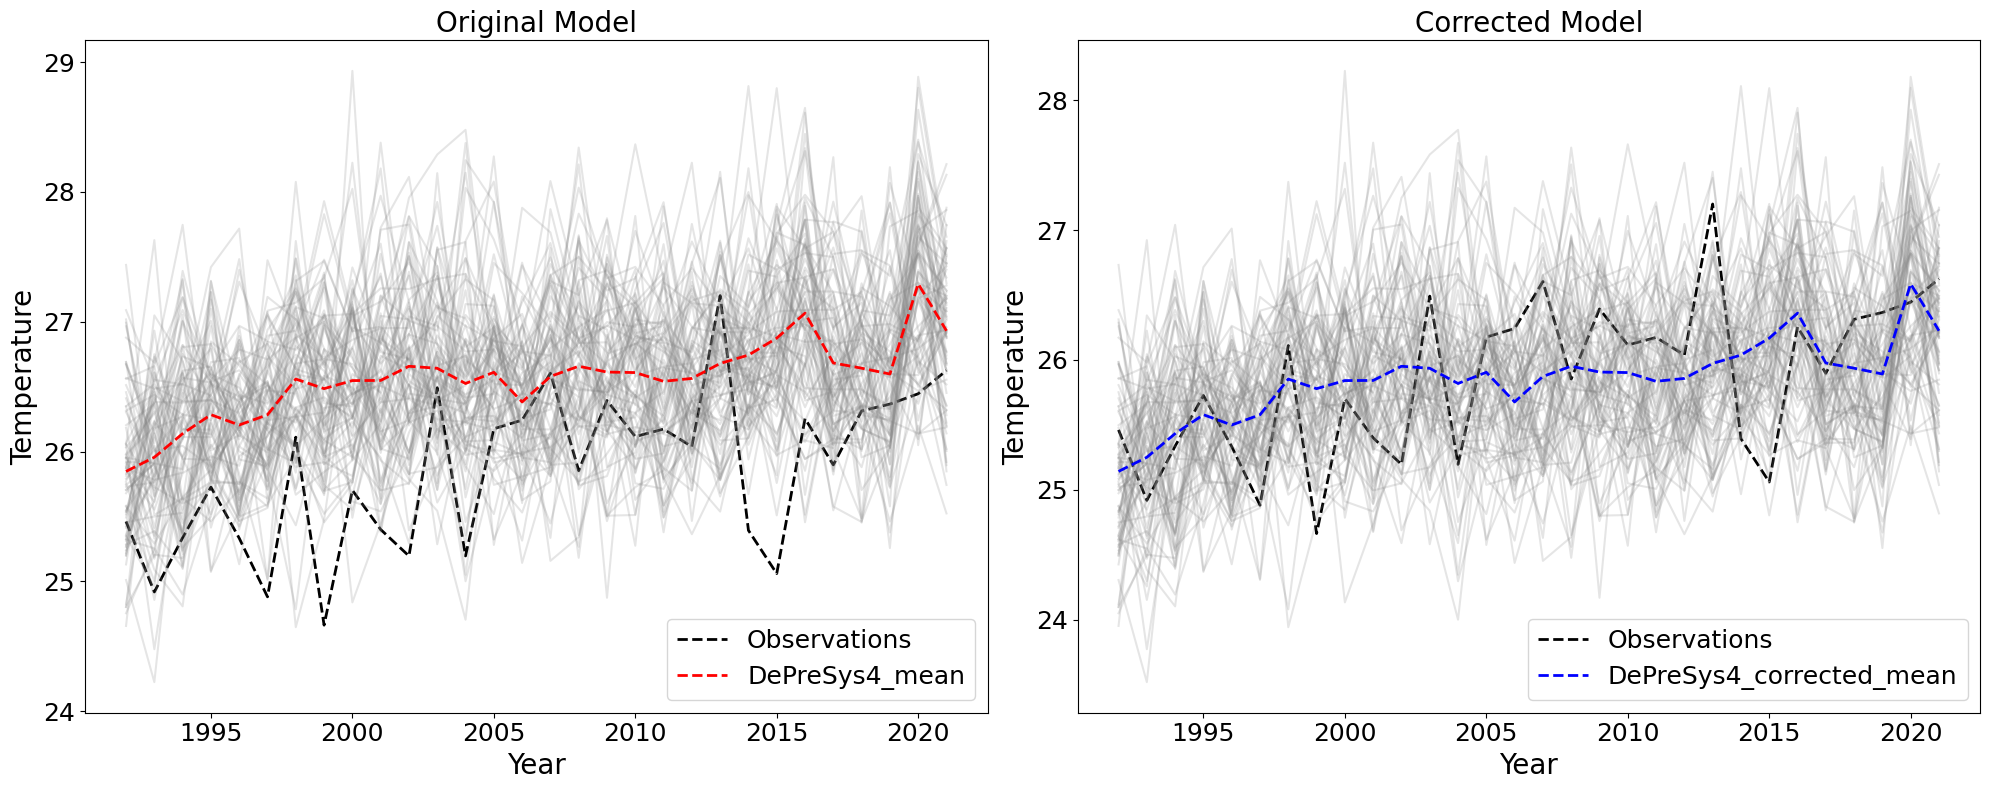

Hunan Summer Temperature for DePreSys4 Data:


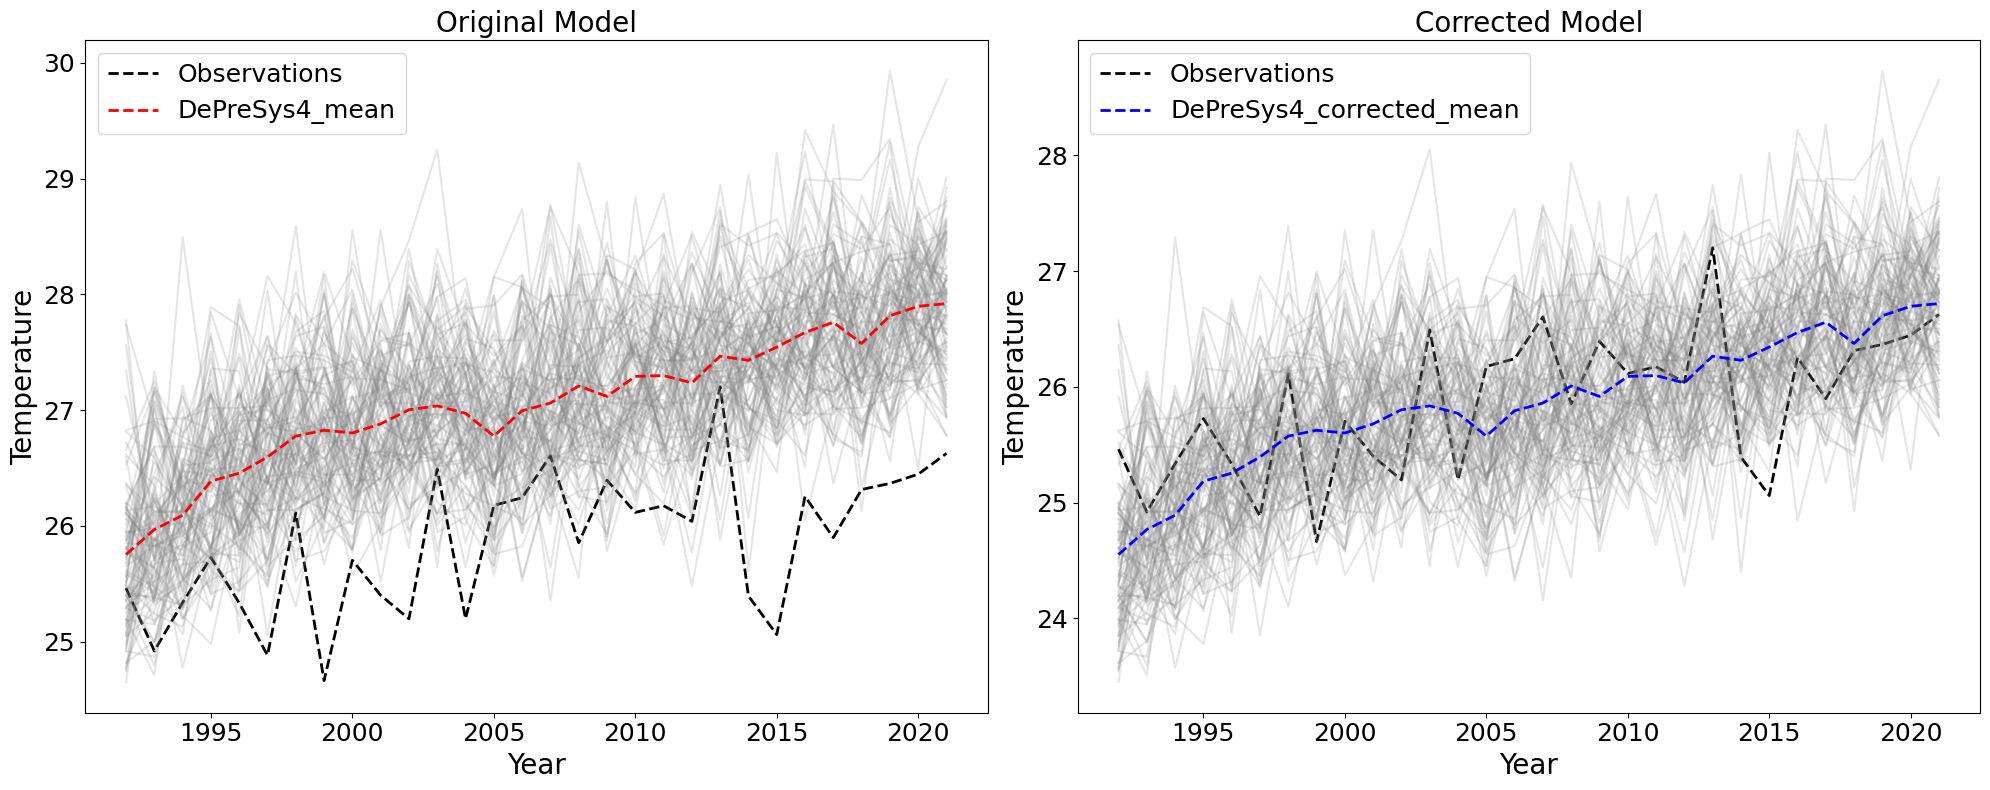

In [50]:
print("Hunan Summer Temperature for DePreSys3 Data:")
plotting_obs_mod(obs, mod3, model3_meancor)
print("Hunan Summer Temperature for DePreSys4 Data:")
plotting_obs_mod(obs, mod4, model4_meancor)

print("Hunan Summer Temperature for DePreSys3 Data:")
plotting_obs_mod(obs, new_mod3, new_model3_meancor)
print("Hunan Summer Temperature for DePreSys4 Data:")
plotting_obs_mod(obs, new_mod4, new_model4_meancor)

In [13]:
print("Hunan Summer Temperature for DePreSys3 Data:")
plotting_obs_mod(obs, mod3, model3_meancor)
print("Hunan Summer Temperature for DePreSys4 Data:")
plotting_obs_mod(obs, mod4, model4_meancor)

Hunan Summer Temperature for DePreSys3 Data:


NameError: name 'model3_meancor' is not defined

## Fidelity Test

In [19]:
print("(1) result of fidelity testing for DePreSys3 data:\n")
stats_measures3=timeseries_fid_test(obs.data,model3)
print("\n(2) result of fidelity testing for DePreSys4 data:\n")
stats_measures4=timeseries_fid_test(obs.data,model4)

print("(1) result of fidelity testing for DePreSys3 data:\n")
new_stats_measures3=timeseries_fid_test(obs.data,new_model3)
print("\n(2) result of fidelity testing for DePreSys4 data:\n")
new_stats_measures4=timeseries_fid_test(obs.data,new_model4)

(1) result of fidelity testing for DePreSys3 data:

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 0.0
Standard deviation perc: 54.300000000000004
Skewness perc: 29.14
Kurtosis perc: 10.42
Linear trend perc: 96.06

(2) result of fidelity testing for DePreSys4 data:

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 0.0
Standard deviation perc: 3.74
Skewness perc: 52.21
Kurtosis perc: 19.84
Linear trend perc: 99.62
(1) result of fidelity testing for DePreSys3 data:

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 0.0
Standard deviation perc: 41.29
Skewness perc: 33.15
Kurtosis perc: 15.15
Linear trend perc: 85.7

(2) result of fidelity testing for DePreSys4 data:

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 0.0
Standard deviation perc: 12.42
Skewness perc: 28.79
Kurtosis perc: 26.22
Linear trend perc: 58.440000000000005


plotting


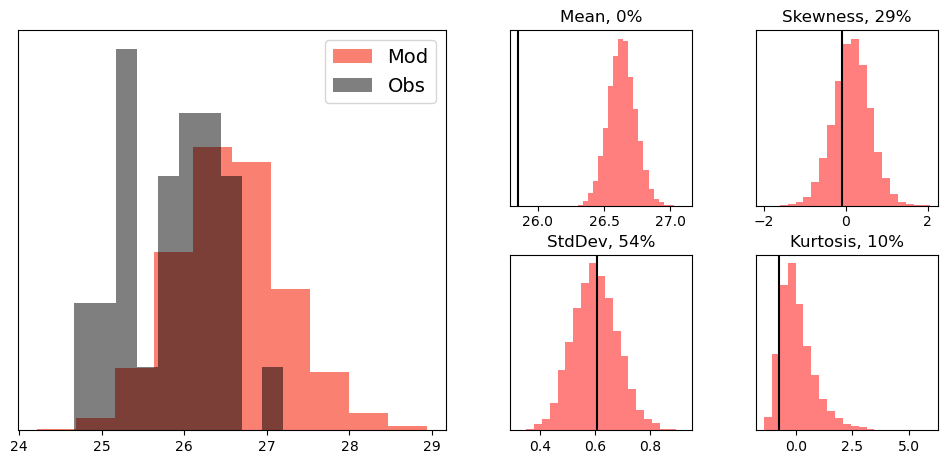

plotting


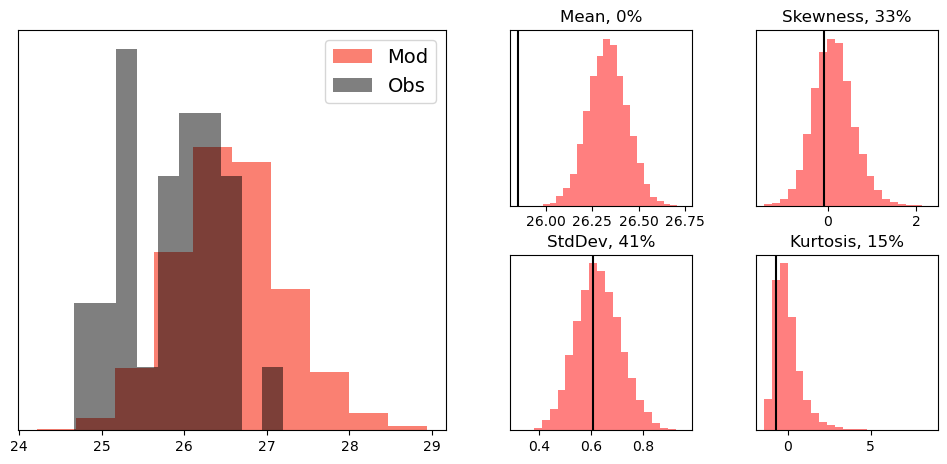

In [21]:
plot_fidelity_testing(obs.data, model3, stats_measures3, 0.1,"fidelity test for DePreSys3 temperature data","1.png")
plot_fidelity_testing(obs.data, new_model3, new_stats_measures3, 0.1,"fidelity test for DePreSys3 temperature data","1.png")

plotting


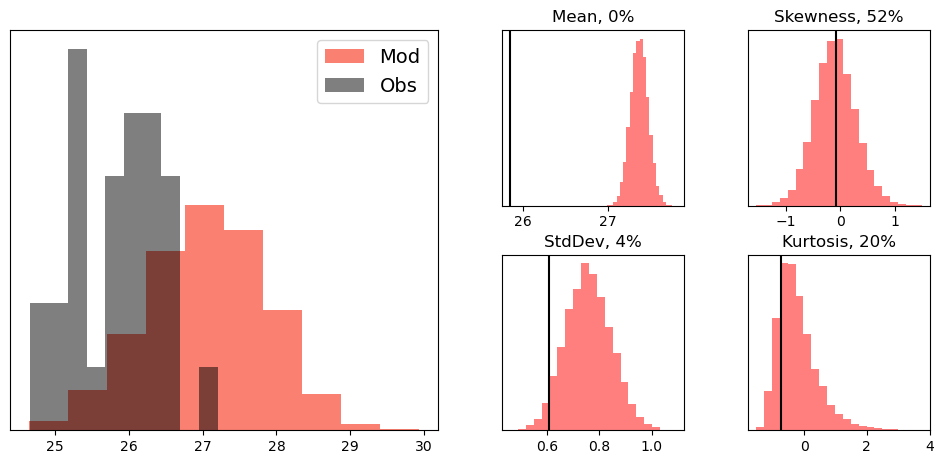

plotting


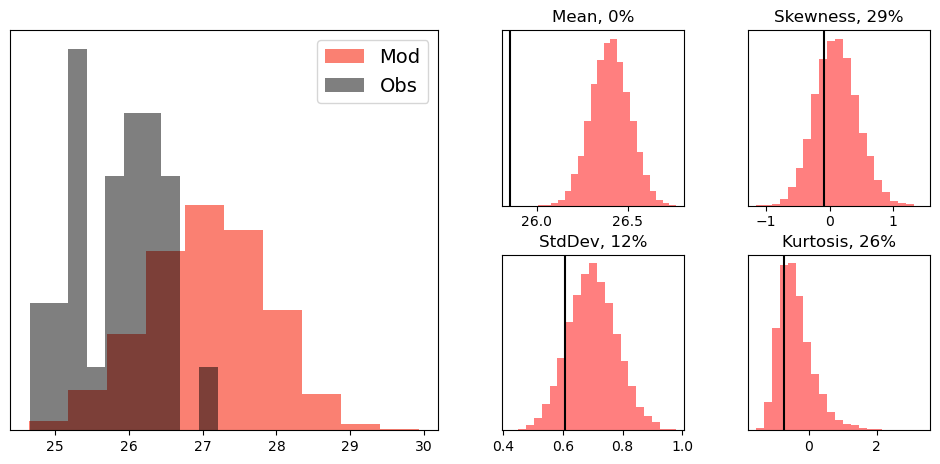

In [22]:
plot_fidelity_testing(obs.data, model4, stats_measures4, 0.1,"","2.png")
plot_fidelity_testing(obs.data, new_model4, new_stats_measures4, 0.1,"","2.png")

## Bias Correction

### 1) DePreSys3 Data : 

In [23]:
model3_meancor= mean_bias_correction(obs.data, mod3.data)
new_model3_meancor= mean_bias_correction(obs.data, new_mod3.data)

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 22.79
Standard deviation perc: 53.239999999999995
Skewness perc: 29.15
Kurtosis perc: 10.52
Linear trend perc: 96.32
plotting


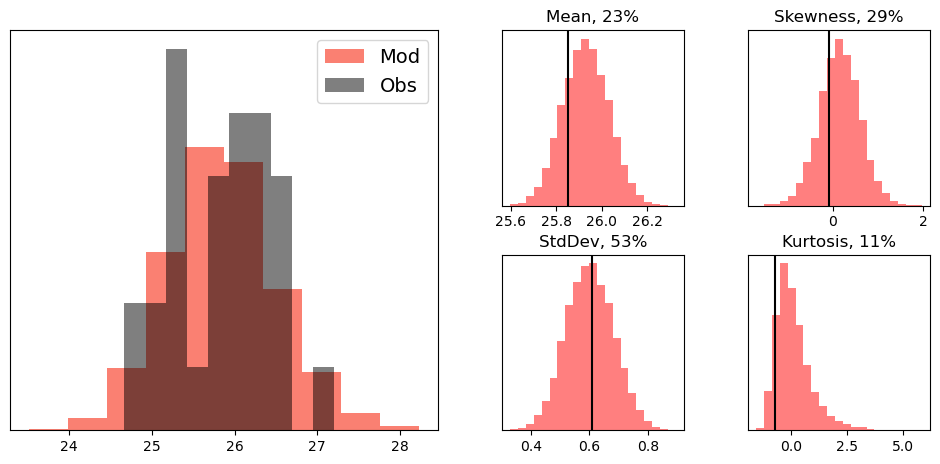

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 98.4
Standard deviation perc: 41.04
Skewness perc: 33.589999999999996
Kurtosis perc: 15.24
Linear trend perc: 85.45
plotting


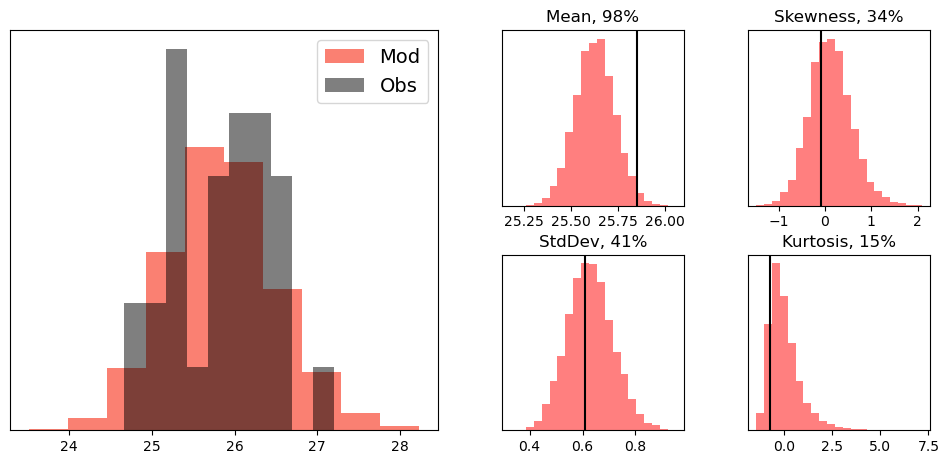

In [24]:
stats_measures_cor3=timeseries_fid_test(obs.data,model3_meancor)
plot_fidelity_testing(obs.data, model3_meancor, stats_measures_cor3, 0.1,"","1.png")
new_stats_measures_cor3=timeseries_fid_test(obs.data,new_model3_meancor)
plot_fidelity_testing(obs.data, new_model3_meancor, new_stats_measures_cor3, 0.1,"","1.png")

In [ ]:
model3_kurtcor = kurtosis_power_transform(model3)

In [ ]:
stats_measures_cor3=timeseries_fid_test(obs.data,model3_kurtcor)
plot_fidelity_testing(obs.data, model3_kurtcor, stats_measures_cor3, 0.1,"Kurtosis Correction for DePreSys3 Temperature data  ","1.png")

### 2) DePreSys4 Data Bias Correction:

plotting


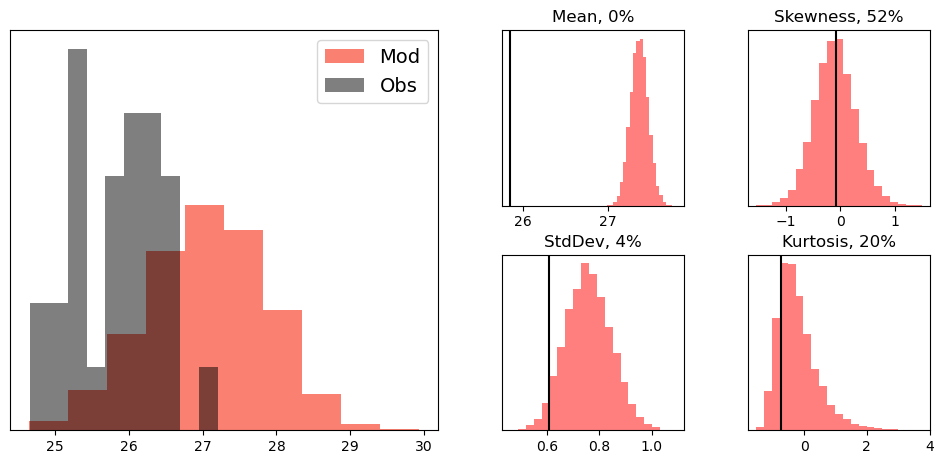

plotting


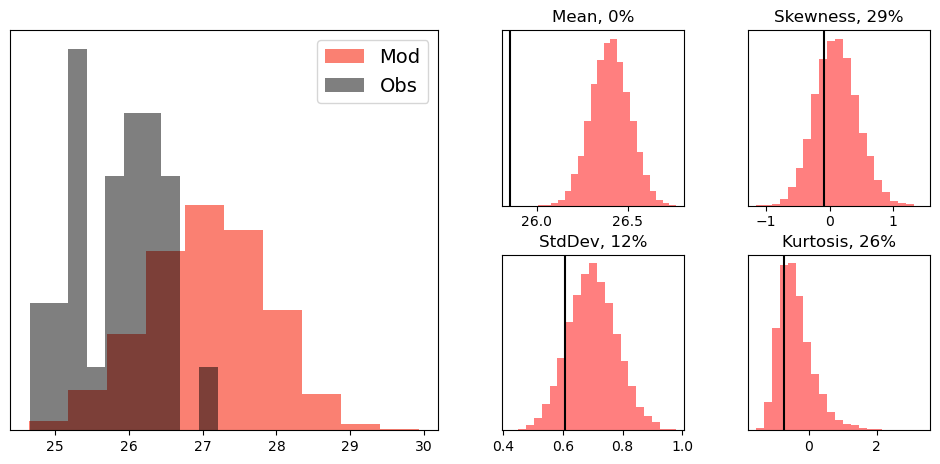

In [26]:
plot_fidelity_testing(obs.data, mod4.data, stats_measures4, 0.1,"Fidelity test for DePreSys4 Temperature data","2.png")
plot_fidelity_testing(obs.data, new_mod4.data, new_stats_measures4, 0.1,"Fidelity test for DePreSys4 Temperature data","2.png")

In [27]:
model4_meancor= mean_bias_correction(obs.data, mod4.data)
print("mod mean:",mod4.data.mean())
print("mod_cor mean:",model4_meancor.mean())
print("obs mean",obs.data.mean())

new_model4_meancor= mean_bias_correction(obs.data, new_mod4.data)
print("mod mean:",new_mod4.data.mean())
print("mod_cor mean:",new_model4_meancor.mean())
print("obs mean",obs.data.mean())

mod mean: 27.05304104789102
mod_cor mean: 25.852407660620063
obs mean 25.852407660620063
mod mean: 27.05304104789102
mod_cor mean: 25.852407660620063
obs mean 25.852407660620063


Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 0.15
Standard deviation perc: 3.8899999999999997
Skewness perc: 52.400000000000006
Kurtosis perc: 19.82
Linear trend perc: 99.42999999999999
plotting


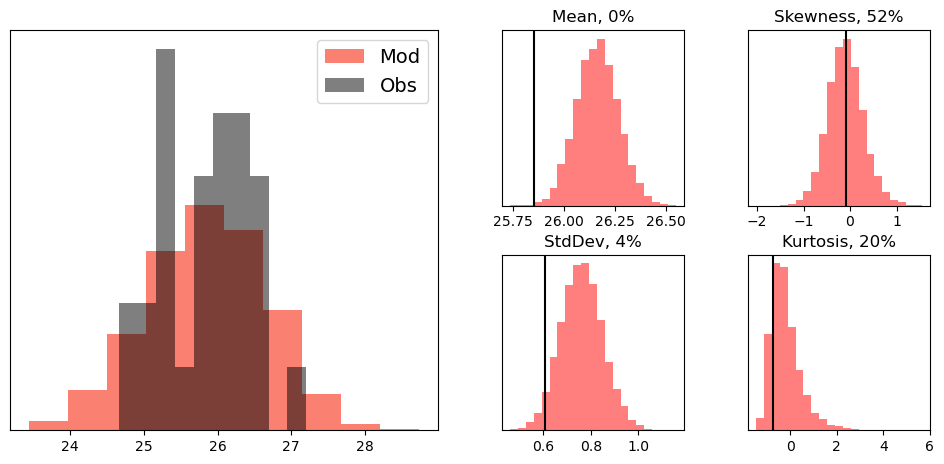

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 99.99
Standard deviation perc: 12.91
Skewness perc: 29.439999999999998
Kurtosis perc: 25.19
Linear trend perc: 58.24
plotting


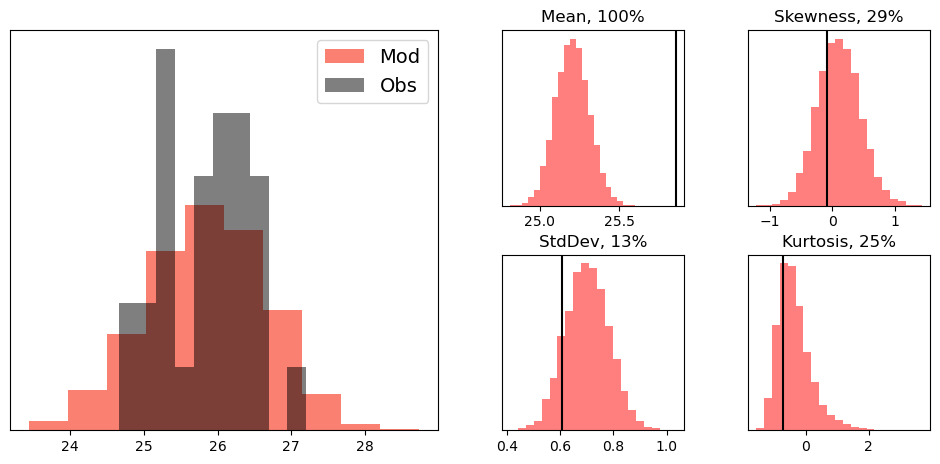

In [28]:
stats_measures_cor4=timeseries_fid_test(obs.data,model4_meancor)
plot_fidelity_testing(obs.data, model4_meancor, stats_measures_cor4, 0.1,"Mean Bias Correction for DePreSys4 data","1.png")
new_stats_measures_cor4=timeseries_fid_test(obs.data,new_model4_meancor)
plot_fidelity_testing(obs.data, new_model4_meancor, new_stats_measures_cor4, 0.1,"Mean Bias Correction for DePreSys4 data","1.png")

In [29]:
model4_ratiocor= ratio_correction(obs.data, mod4.data)
print("mod mean:",mod4.data.mean())
print("mod_cor mean:",model4_ratiocor.mean())
print("obs mean",obs.data.mean())

new_model4_ratiocor= ratio_correction(obs.data, new_mod4.data)
print("mod mean:",new_mod4.data.mean())
print("mod_cor mean:",new_model4_ratiocor.mean())
print("obs mean",obs.data.mean())

mod mean: 27.05304104789102
mod_cor mean: 25.852407660620063
obs mean 25.852407660620063
mod mean: 27.05304104789102
mod_cor mean: 25.852407660620063
obs mean 25.852407660620063


Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 0.08
Standard deviation perc: 71.58
Skewness perc: 53.02
Kurtosis perc: 20.26
Linear trend perc: 99.99
plotting


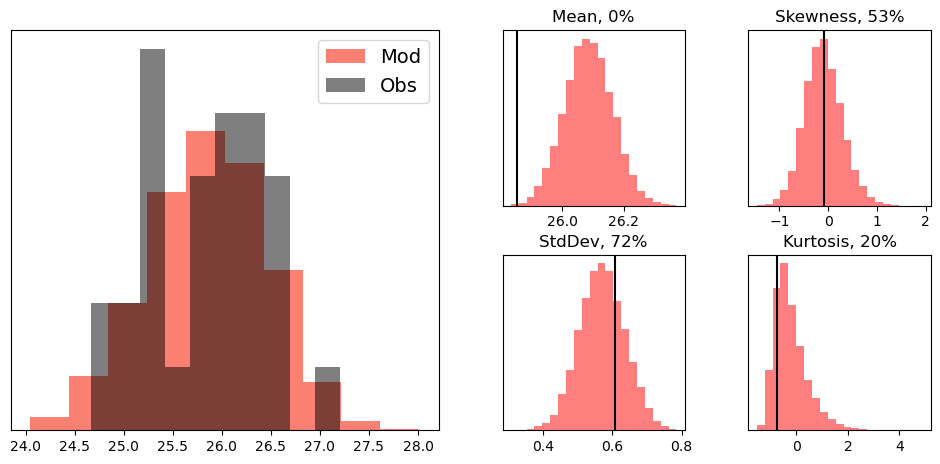

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 99.99
Standard deviation perc: 90.28
Skewness perc: 28.22
Kurtosis perc: 24.51
Linear trend perc: 90.55
plotting


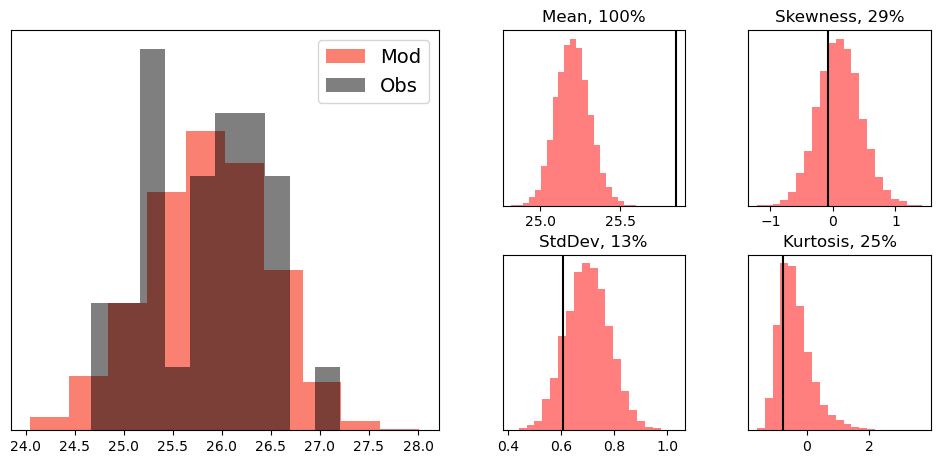

In [30]:
stats_measures_cor4=timeseries_fid_test(obs.data,model4_ratiocor)
plot_fidelity_testing(obs.data, model4_ratiocor, stats_measures_cor4, 0.1,"Ratio Bias Correction for DePreSys4 data","1.png")

stats_measures_cor4=timeseries_fid_test(obs.data,new_model4_ratiocor)
plot_fidelity_testing(obs.data, new_model4_ratiocor, new_stats_measures_cor4, 0.1,"Ratio Bias Correction for DePreSys4 data","1.png")

In [31]:
model4_kurtcor = kurtosis_power_transform(model4_meancor)
new_model4_kurtcor = kurtosis_power_transform(new_model4_meancor)

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 0.1
Standard deviation perc: 1.9300000000000002
Skewness perc: 54.1
Kurtosis perc: 43.28
Linear trend perc: 99.76
plotting


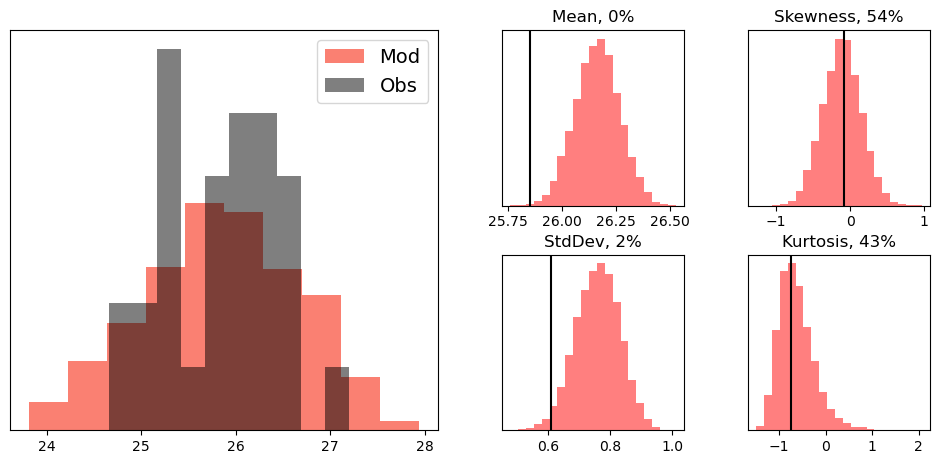

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 99.99
Standard deviation perc: 7.53
Skewness perc: 40.42
Kurtosis perc: 63.160000000000004
Linear trend perc: 58.86
plotting


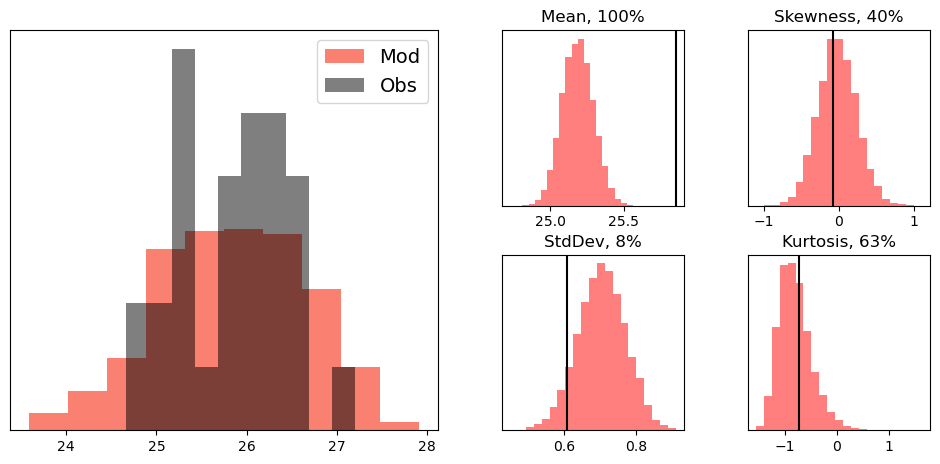

In [32]:
stats_measures_cor4=timeseries_fid_test(obs.data,model4_kurtcor)
plot_fidelity_testing(obs.data, model4_kurtcor, stats_measures_cor4, 0.1,"Kurtsis Bias Correction for DePreSys4 data","1.png")

new_stats_measures_cor4=timeseries_fid_test(obs.data,new_model4_kurtcor)
plot_fidelity_testing(obs.data, new_model4_kurtcor, new_stats_measures_cor4, 0.1,"Kurtsis Bias Correction for DePreSys4 data","1.png")

In [ ]:
stats_measures_cor4=timeseries_fid_test(obs.data,model4_meancor)
plot_fidelity_testing(obs.data, model4_meancor, stats_measures_cor4, 0.1,"Mean Correction for DePreSys4 data","1.png")

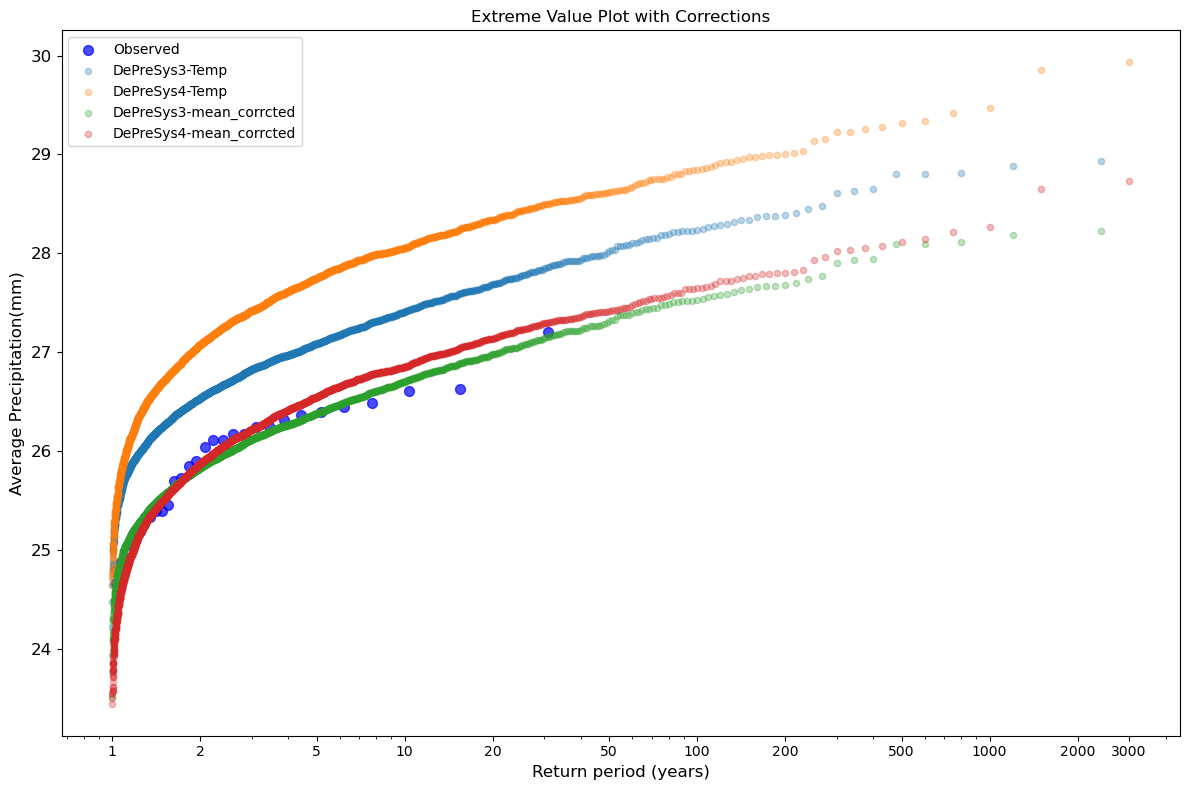

In [33]:
# comparison in return periods
obs_data = obs.data
models_data = [mod3.data, mod4.data, model3_meancor,model4_meancor]
model_names = ['DePreSys3-Temp', 'DePreSys4-Temp', 'DePreSys3-mean_corrcted','DePreSys4-mean_corrcted']
plot_return_periods(obs_data, models_data, model_names, n_years=30)

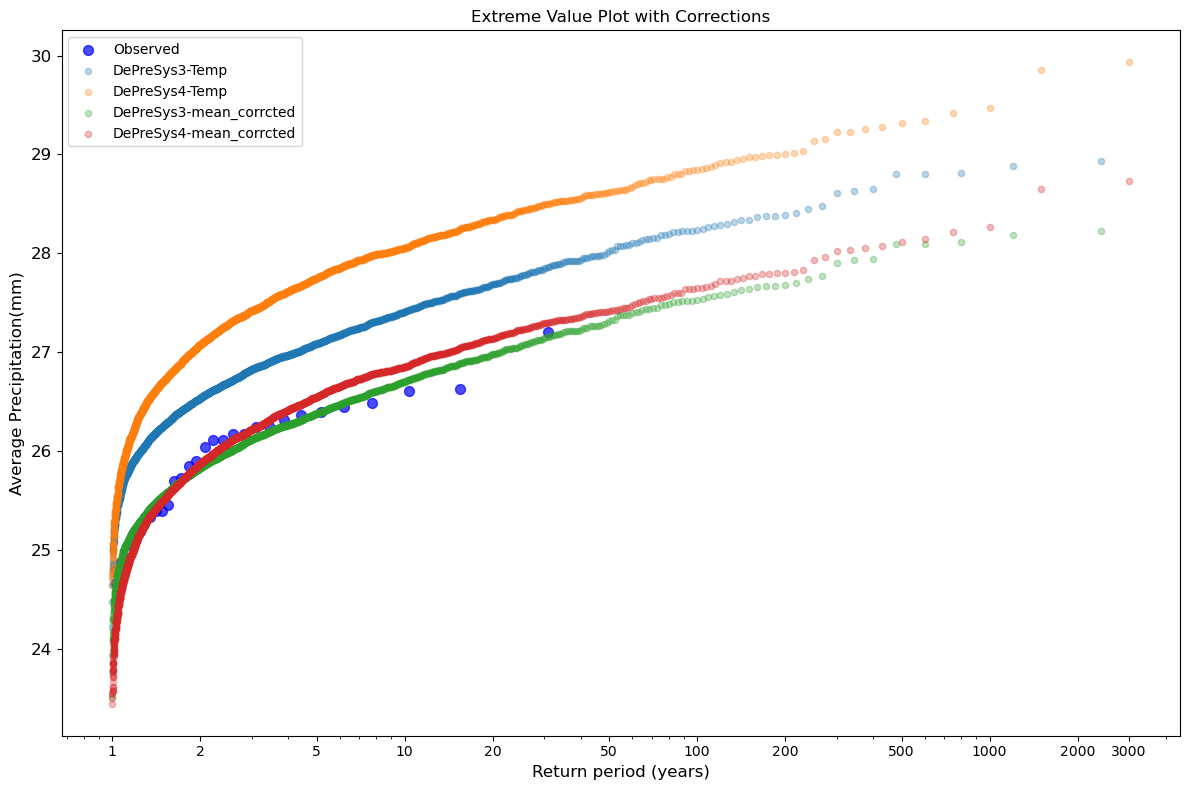

In [34]:
# comparison in return periods
obs_data = obs.data
new_models_data = [new_mod3.data, new_mod4.data, new_model3_meancor,new_model4_meancor]
model_names = ['DePreSys3-Temp', 'DePreSys4-Temp', 'DePreSys3-mean_corrcted','DePreSys4-mean_corrcted']
plot_return_periods(obs_data, new_models_data, model_names, n_years=30)

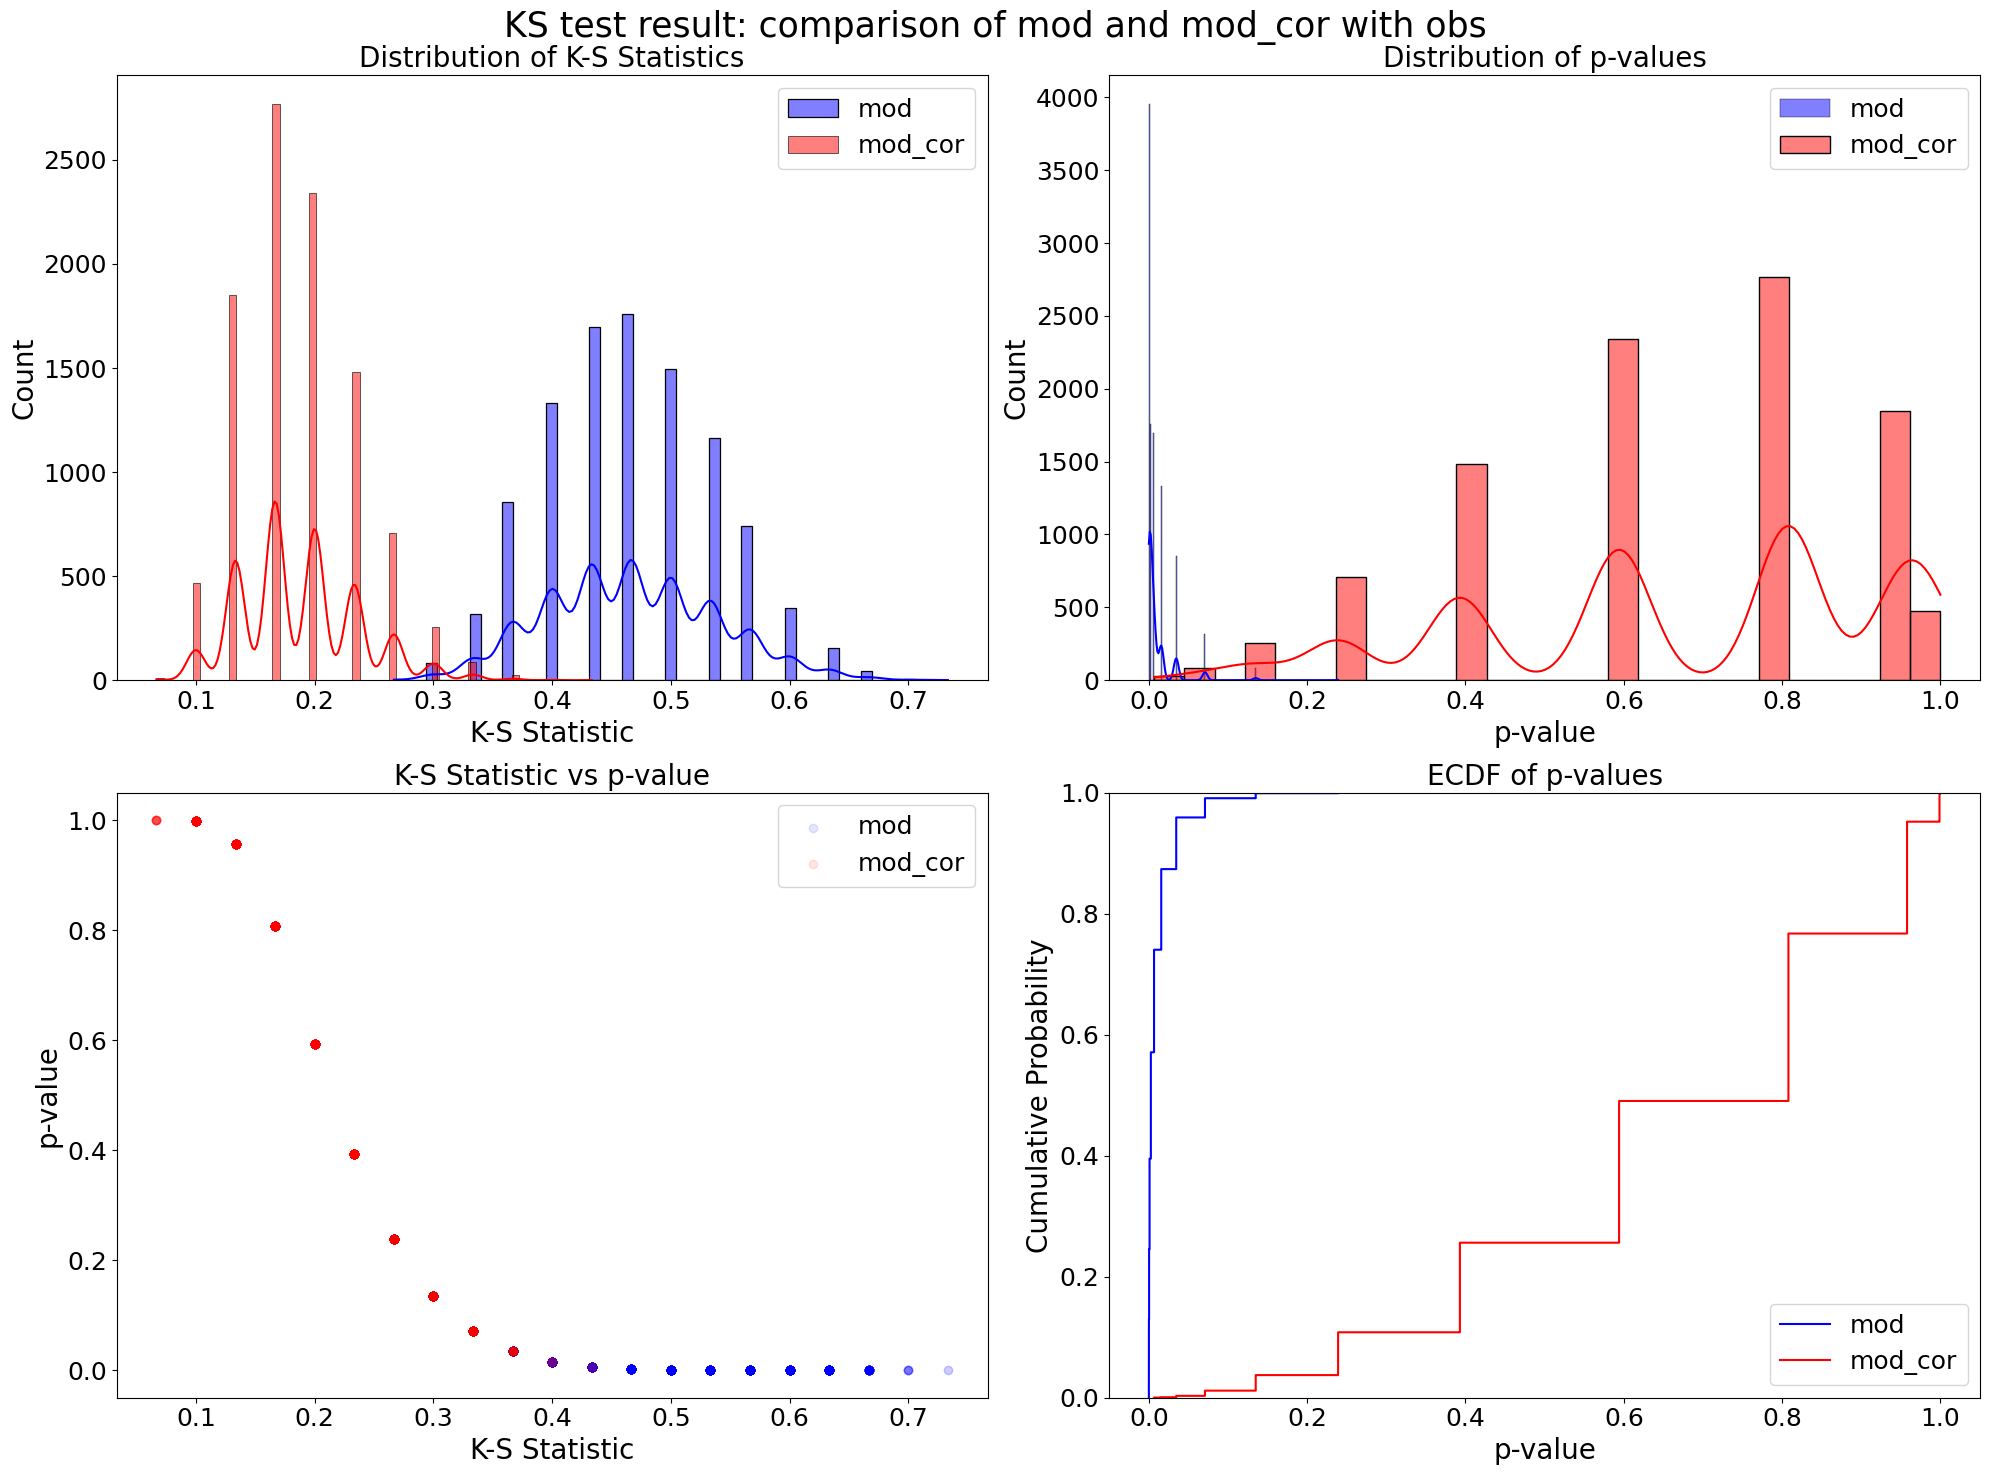

Summary for mod:
Mean K-S Statistic: 0.4663
Mean p-value: 0.0103
Proportion of significant results (p < 0.05): 95.93%


Summary for mod_cor:
Mean K-S Statistic: 0.1876
Mean p-value: 0.6669
Proportion of significant results (p < 0.05): 0.31%


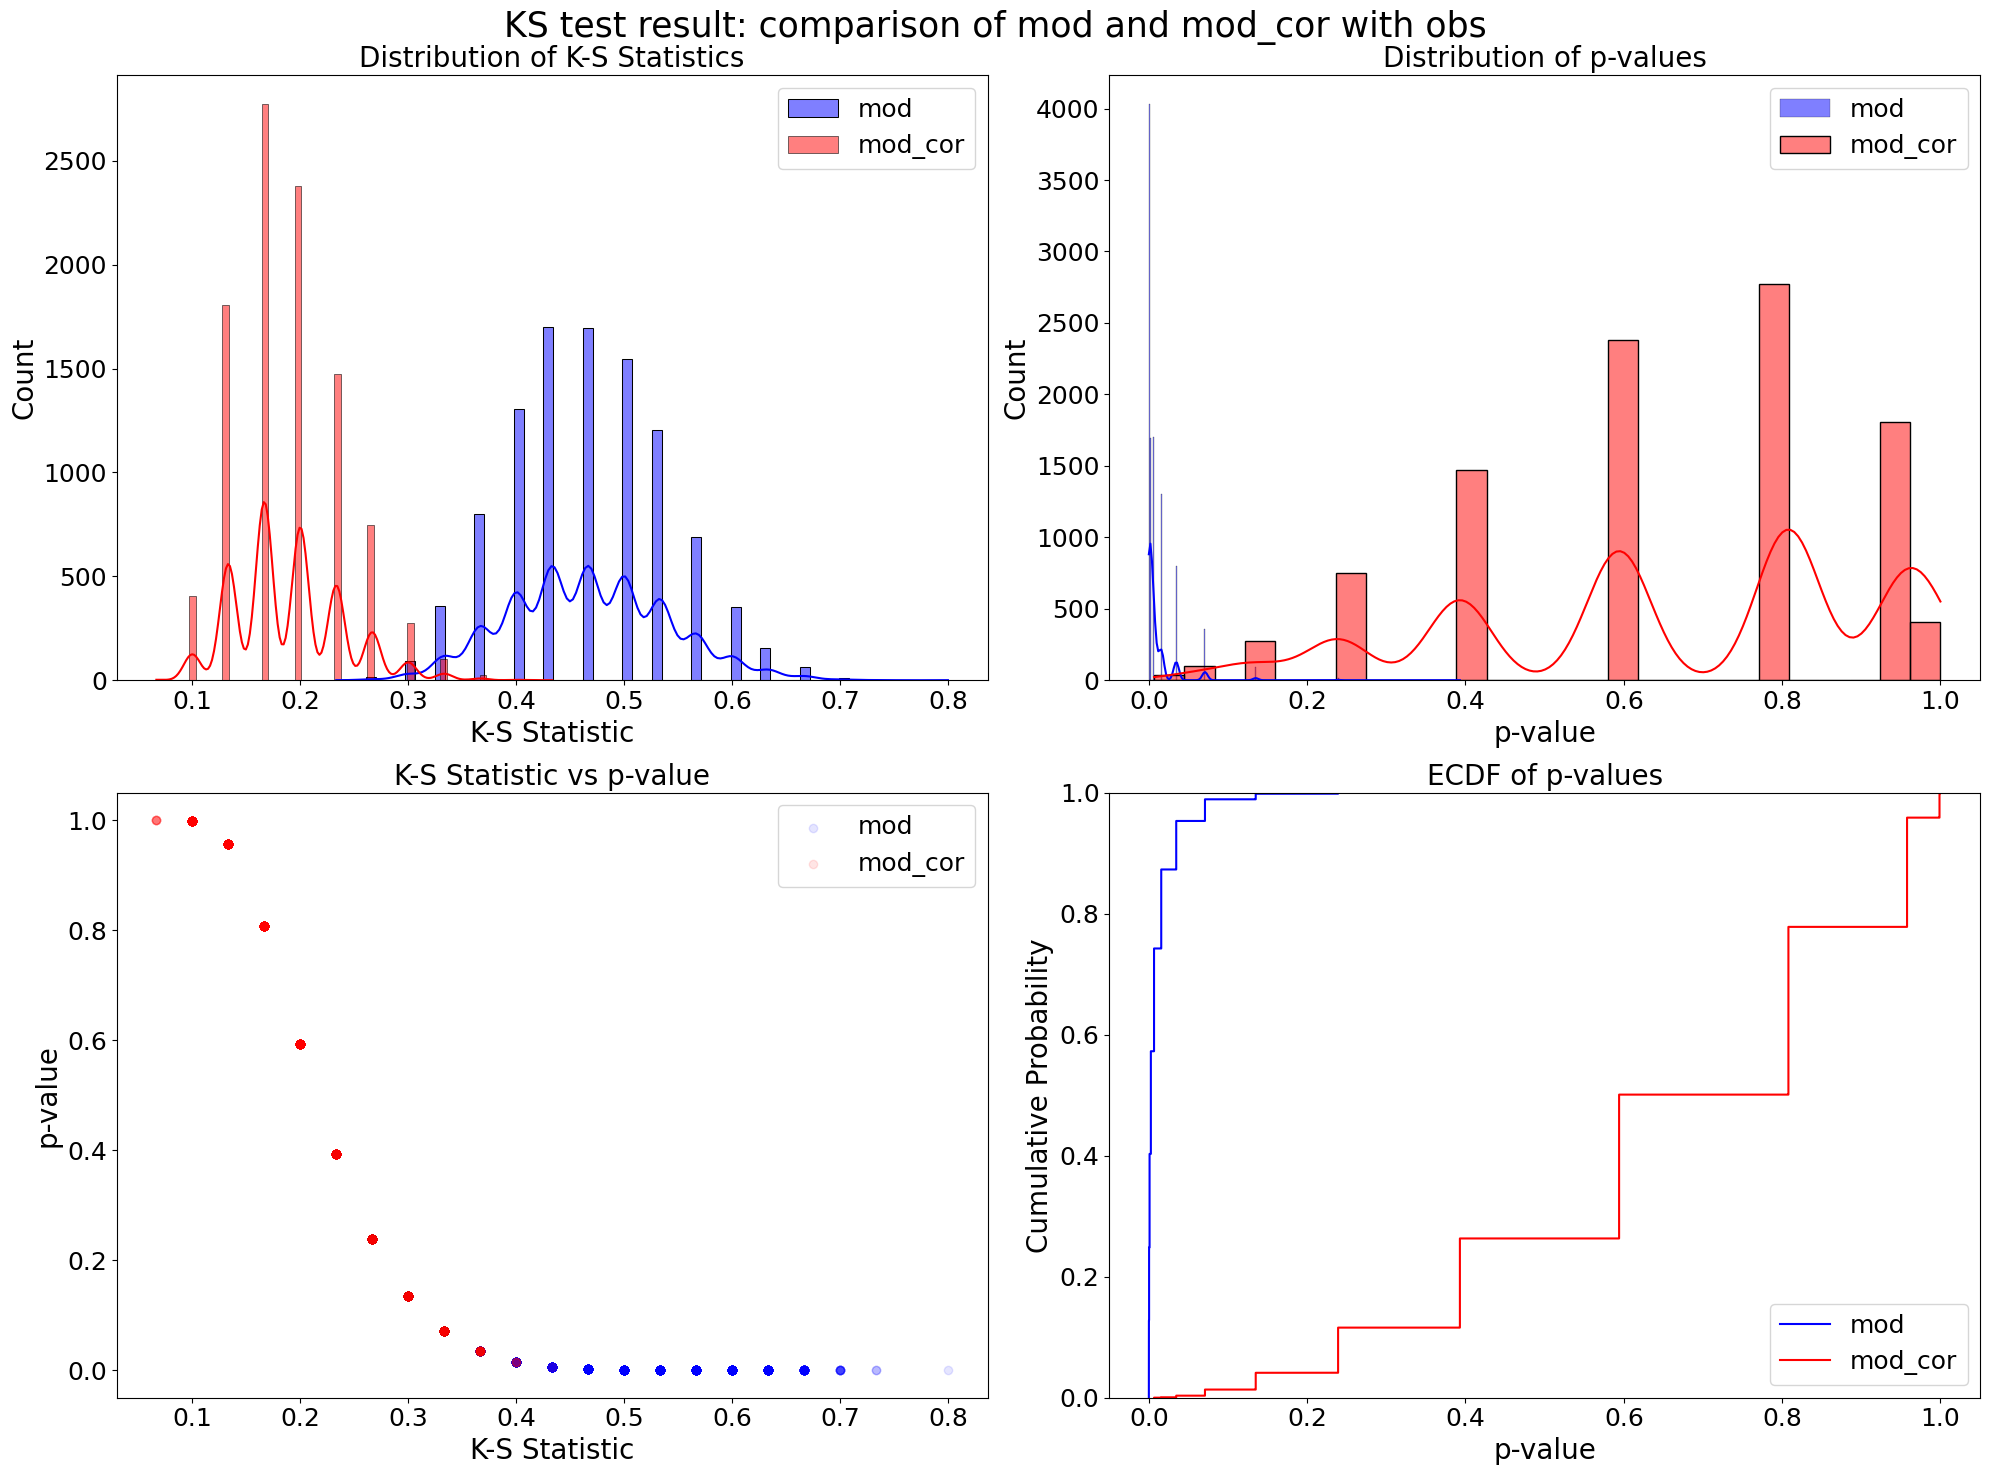

Summary for mod:
Mean K-S Statistic: 0.4667
Mean p-value: 0.0107
Proportion of significant results (p < 0.05): 95.35%


Summary for mod_cor:
Mean K-S Statistic: 0.1892
Mean p-value: 0.6596
Proportion of significant results (p < 0.05): 0.34%


In [36]:
ks_compare_distributions(obs.data, mod3.data,model3_meancor)

ks_compare_distributions(obs.data, new_mod3.data,new_model3_meancor)

## AD test

In [ ]:
def ensemble_bootstrap(mod_data, n_samples=10000):
    years, ensembles = mod_data.shape
    all_samples = np.zeros((years, n_samples))
    for i in range(n_samples):
        for year in range(years):
            ensemble = np.random.choice(ensembles)
            all_samples[year, i] = mod_data[year, ensemble]

    return all_samples

In [ ]:
def perform_anderson_darling_test(obs_data, sample_data):
    p_values = []
    for i in range(sample_data.shape[1]):
        sample = sample_data[:, i]
        try:
            result = stats.anderson_ksamp([obs_data, sample])
            if isinstance(result, tuple):
                p_value = result[2]  
            else:
                p_value = result.significance_level
            p_values.append(p_value)
        except ValueError as e:
            print(f"Error in sample {i}: {e}")
            p_values.append(np.nan)    
    return np.array(p_values)



In [ ]:
# A-D test
bootstrap_samples = ensemble_bootstrap(mod4.data, n_samples=10000)
print("bootstrap_samples shape:", mod4.data.shape)
p_values = perform_anderson_darling_test(obs.data, mod4.data)
proportion_consistent = np.mean(p_values > 0.05)
print(f"Proportion of simulations consistent with observations: {proportion_consistent:.3%}")


bootstrap_samples1 = ensemble_bootstrap(model4_meancor, n_samples=10000)
print("bootstrap_samples shape:", model4_meancor.shape)
p_values1 = perform_anderson_darling_test(obs.data, model4_meancor)
proportion_consistent1 = np.mean(p_values1 > 0.05)
print(f"Proportion of simulations consistent with observations: {proportion_consistent1:.3%}")


In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(p_values, bins=50, edgecolor='black')
plt.title('Anderson_Darling Test Result ')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.axvline(0.05, color='r', linestyle='dashed', linewidth=2)
plt.text(0.045, plt.ylim()[1]*0.9, 'p=0.05', color='r', rotation=90, va='top')

plt.subplot(122)
plt.hist(p_values1, bins=50, edgecolor='black')
plt.title('Anderson Darling Test Result for corrected data')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.axvline(0.05, color='r', linestyle='dashed', linewidth=2)
plt.text(0.06, plt.ylim()[1]*0.9, 'p=0.05', color='r', rotation=90, va='top')
plt.tight_layout()
plt.show()
p_values.max()

In [ ]:
# comparison in return periods
obs_data = obs.data
models_data = [mod3.data,mod4.data, model3_meancor, model4_meancor]
model_names = [ 'DePreSys3-Temp','DePreSys4-Temp','DePreSys3-corrcted','DePreSys4-corrcted']
plot_return_periods(obs_data, models_data, model_names, n_years=30)

# Analysis

In [38]:

print("Mod max:", np.max(mod3.data))
print("Mod min:", np.min(mod3.data))
print("Mod mean:", np.mean(mod3.data))

print("Mod max:", np.max(new_mod3.data))
print("Mod min:", np.min(new_mod3.data))
print("Mod mean:", np.mean(new_mod3.data))

print("Mod max:", np.max(model3_meancor))
print("Mod min:", np.min(model3_meancor))
print("Mod mean:", np.mean(model3_meancor))

print("Mod max:", np.max(new_model3_meancor))
print("Mod min:", np.min(new_model3_meancor))
print("Mod mean:", np.mean(new_model3_meancor))

#obs = obs.data
mod = model3_meancor
new_mod = new_model3_meancor

Mod max: 28.932973273559707
Mod min: 24.223782516642075
Mod mean: 26.55818976190328
Mod max: 28.932973273559707
Mod min: 24.223782516642075
Mod mean: 26.55818976190328
Mod max: 28.22719117227649
Mod min: 23.51800041535886
Mod mean: 25.852407660620067
Mod max: 28.22719117227649
Mod min: 23.51800041535886
Mod mean: 25.852407660620067


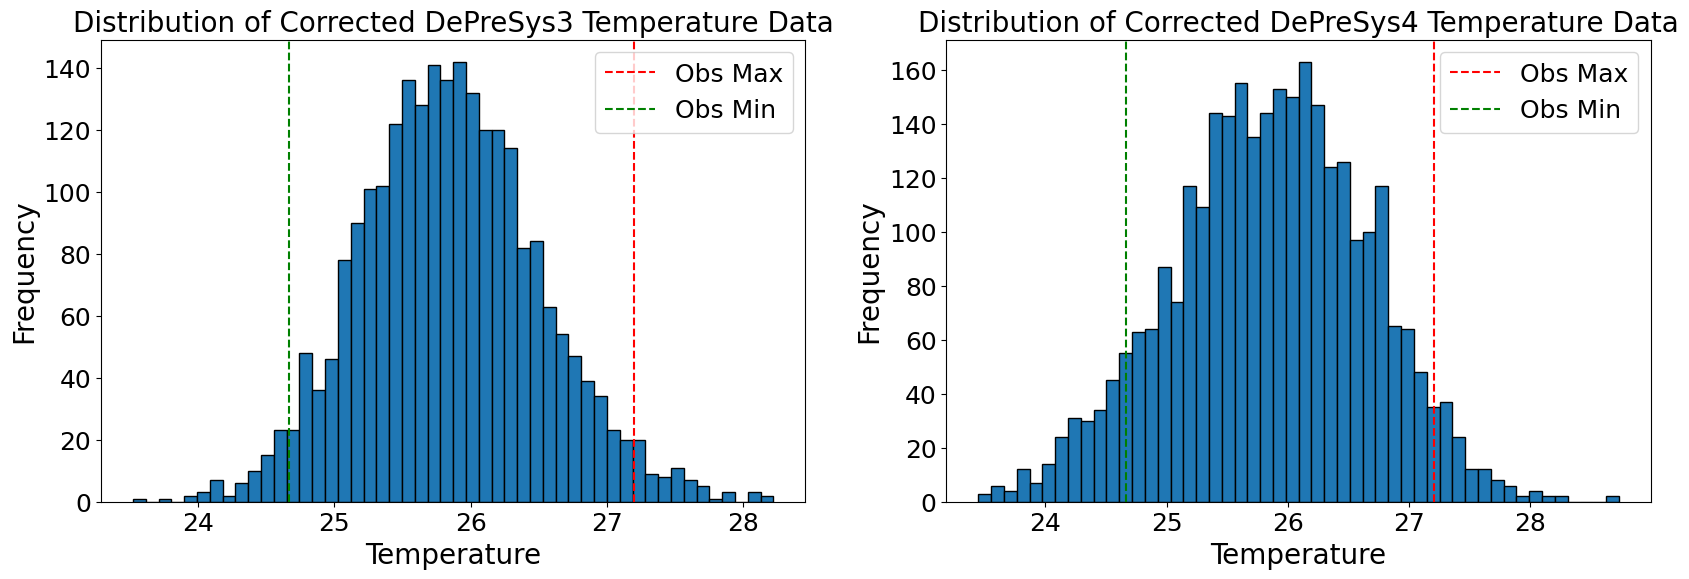

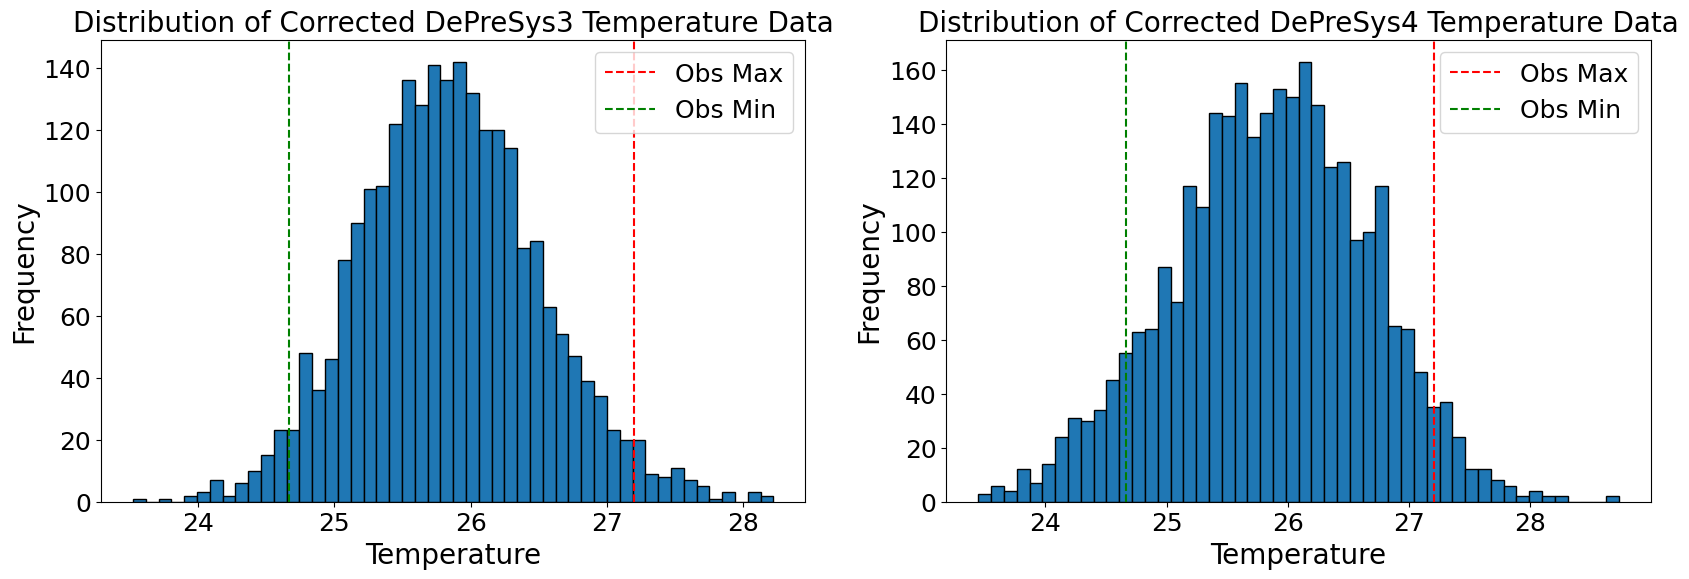

In [40]:
obs_max = np.max(obs.data)
obs_min = np.min(obs.data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# 第一个子图：完整的mod分布
ax1.hist(model3_meancor.flatten(), bins=50, edgecolor='black')
ax1.axvline(obs_max, color='red', linestyle='--', label='Obs Max')
ax1.axvline(obs_min, color='green', linestyle='--', label='Obs Min')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Corrected DePreSys3 Temperature Data')
ax1.legend()

ax2.hist(model4_meancor.flatten(), bins=50, edgecolor='black')
ax2.axvline(obs_max, color='red', linestyle='--', label='Obs Max')
ax2.axvline(obs_min, color='green', linestyle='--', label='Obs Min')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Corrected DePreSys4 Temperature Data')
ax2.legend()


obs_max = np.max(obs.data)
obs_min = np.min(obs.data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# 第一个子图：完整的mod分布
ax1.hist(new_model3_meancor.flatten(), bins=50, edgecolor='black')
ax1.axvline(obs_max, color='red', linestyle='--', label='Obs Max')
ax1.axvline(obs_min, color='green', linestyle='--', label='Obs Min')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Corrected DePreSys3 Temperature Data')
ax1.legend()

ax2.hist(new_model4_meancor.flatten(), bins=50, edgecolor='black')
ax2.axvline(obs_max, color='red', linestyle='--', label='Obs Max')
ax2.axvline(obs_min, color='green', linestyle='--', label='Obs Min')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Corrected DePreSys4 Temperature Data')
ax2.legend()

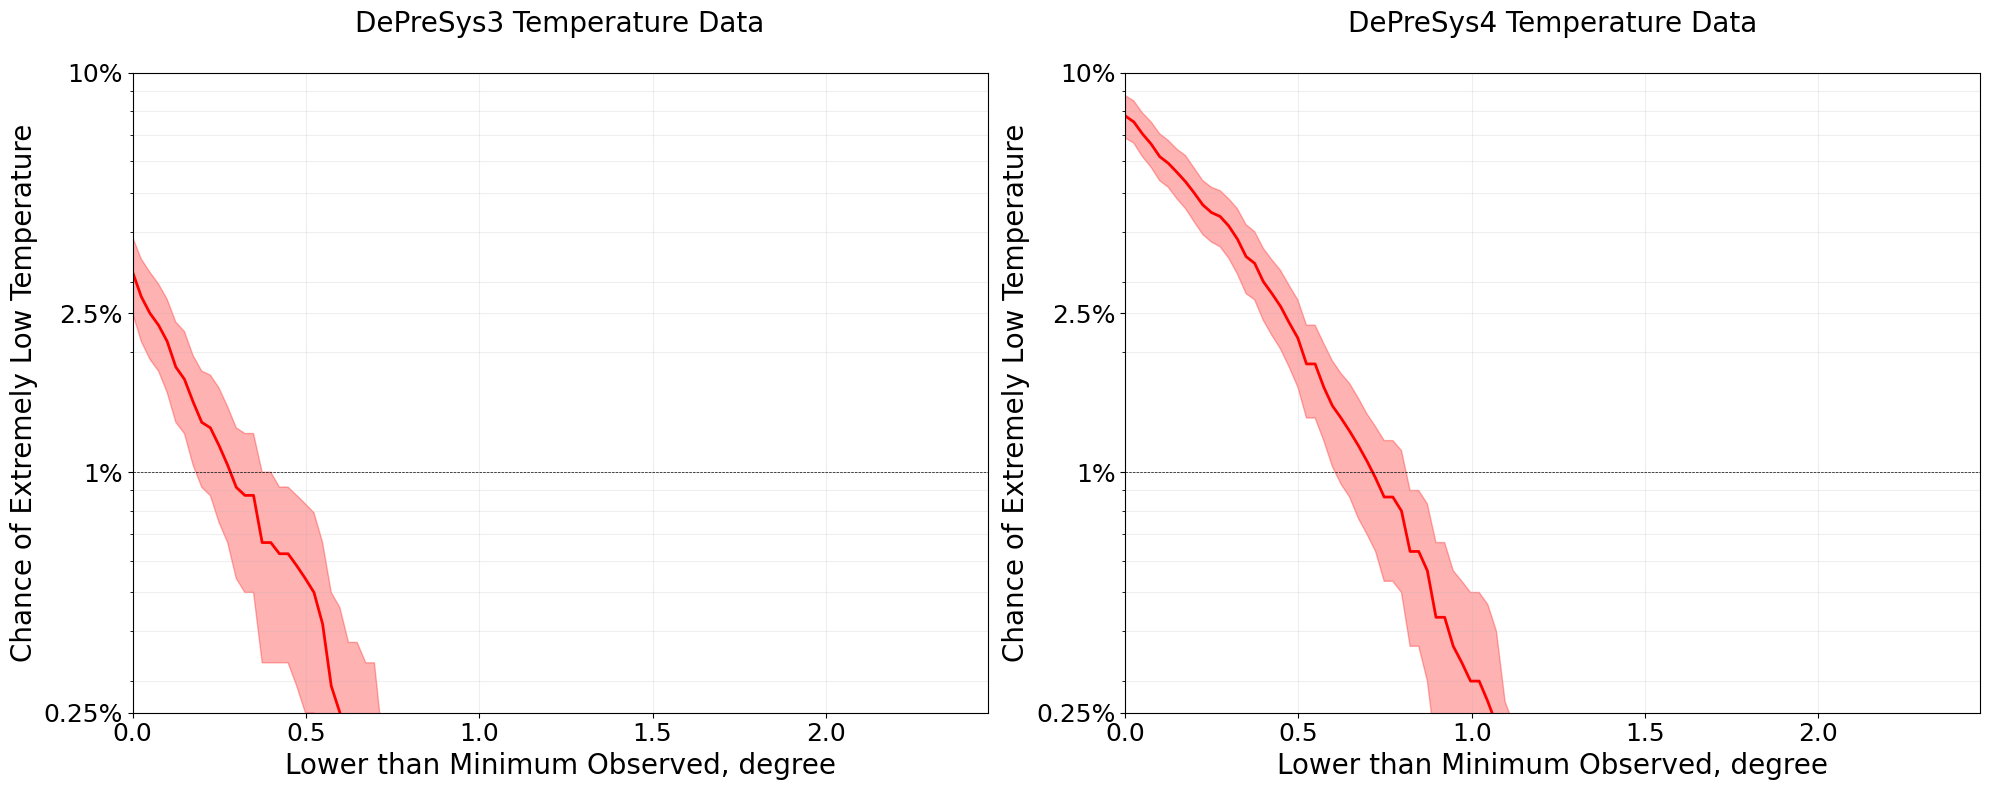

DePreSys3:
Chance of being below the observed minimum: 3.17%
Chance of being below the observed minimum by 1 degree: 0.04%

DePreSys4:
Chance of being below the observed minimum: 7.80%
Chance of being below the observed minimum by 1 degree: 0.30%


In [41]:
def calculate_below_minimum_probability(data, threshold, temp_decrements):
    probs = []
    for temp in temp_decrements:
        prob = np.mean(data.flatten() <= (threshold - temp)) * 100
        probs.append(prob)
    return probs

def plot_below_minimum_probability(ax, mod, obs, title):
    obs_min = np.min(obs)
    max_decrement = obs_min * 0.1
    temp_decrements = np.linspace(0, max_decrement, 100)
    
    probabilities = calculate_below_minimum_probability(mod, obs_min, temp_decrements)
    
    n_bootstrap = 1000
    bootstrap_results = []
    for _ in range(n_bootstrap):
        bootstrap_sample = np.random.choice(mod.flatten(), size=mod.size, replace=True)
        bootstrap_probs = calculate_below_minimum_probability(bootstrap_sample, obs_min, temp_decrements)
        bootstrap_results.append(bootstrap_probs)
    
    lower_bound = np.percentile(bootstrap_results, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_results, 97.5, axis=0)
    
    ax.plot(temp_decrements, probabilities, color='red', linewidth=2)
    ax.fill_between(temp_decrements, lower_bound, upper_bound, color='red', alpha=0.3)
    ax.set_xlabel('Lower than Minimum Observed, degree')
    ax.set_ylabel('Chance of Extremely Low Temperature')
    ax.set_yscale('log')
    ax.set_ylim(0.25, 10)
    ax.set_xlim(0, max_decrement)
    ax.set_yticks([0.25, 1, 2.5, 10])
    ax.set_yticklabels(['0.25%', '1%', '2.5%', '10%'])
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.set_title(title)
    ax.axhline(y=1, color='black', linestyle='--', linewidth=0.5)
    
    return probabilities, temp_decrements

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
prob1, temp_decrements1 = plot_below_minimum_probability(ax1, model3_meancor, obs.data, 'DePreSys3 Temperature Data\n')
prob2, temp_decrements2 = plot_below_minimum_probability(ax2, model4_meancor, obs.data, 'DePreSys4 Temperature Data\n')
plt.tight_layout()
plt.show()

print("DePreSys3:")
print(f"Chance of being below the observed minimum: {prob1[0]:.2f}%")
print(f"Chance of being below the observed minimum by 1 degree: {prob1[np.argmin(np.abs(temp_decrements1 - 1))]:.2f}%")
print("\nDePreSys4:")
print(f"Chance of being below the observed minimum: {prob2[0]:.2f}%")
print(f"Chance of being below the observed minimum by 1 degree: {prob2[np.argmin(np.abs(temp_decrements2 - 1))]:.2f}%")